### Random Forest Notebook

This Notebook is to model the random forest regression to predict the incidence value in Switzerland and Swiss regions.

lags fixen (incValue statt popValue)

die ganzen real time data raushauen, stattdessen lags.

probieren mit verschiedenen lags (52 week lag erstmal und dann gucken, vor allem wegen wetter, pop)


data leakage problem:
- 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import json
from datetime import datetime

### Some Data Preparation

In [3]:
# start modelling here
pop_data = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final_region.csv')
flu_data = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather_data = pd.read_csv('../data/weather/reg_weather.csv')
google_flu_data = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms_data = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')

In [4]:
# Create dataframe for country-level observations, no differentiation between sex or age
flu_CH = flu_data.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()

# Create dataframe for regional observations, no differentiation between sex or age
flu_reg = flu_data.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()

# Drop unknown region entries from flu_region using mask
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

# Select columns required for analysis
selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation':'flu_cases'}, inplace=True)

In [5]:
# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

google_flu_data['Woche'] = google_flu_data['Woche'].apply(lambda x: date_dict[x])
google_symptoms_data['Woche'] = google_symptoms_data['Woche'].apply(lambda x: date_dict[x])

In [6]:
dates = weather_data.date.values
# Convert dates to 'YYYY-Www' ISO week format
iso_week_dates = [datetime.strptime(date, '%Y-%m-%d').isocalendar()[:2] for date in dates]
iso_week_dates = [f'{year}-W{week:02d}' for year, week in iso_week_dates]
weather_data['date'] = iso_week_dates

In [7]:
# Reshape google_flu from wide to long
google_flu_data = google_flu_data.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_flu_data['region'] = google_flu_data['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_flu_data['query'] = google_flu_data['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_flu_data.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_flu_data = google_flu_data.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [8]:
# Reshape google_flu from wide to long
google_symptoms_data = google_symptoms_data.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_symptoms_data['region'] = google_symptoms_data['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_symptoms_data['query'] = google_symptoms_data['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_symptoms_data.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_symptoms_data = google_symptoms_data.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [9]:
merged_data = pd.merge(flu_reg, weather_data, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region']).sort_values(by=['georegion', 'temporal'])
merged_google = pd.merge(google_flu_data, google_symptoms_data, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])

In [10]:
merged_data

,temporal,georegion,flu_cases,incValue,region_x,date,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,...,fièvre_seasonal,fièvre_trend,husten,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend
0,2013-W01,region_1,16876.1,53.33,region_1,2013-W01,3.044123,82.918337,6.597668,-1.041057,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-W02,region_1,33045.6,114.99,region_1,2013-W02,1.899121,85.732108,4.005557,-0.232400,...,7.554113,20.241099,3.724624,-6.176678,2.571313,7.329989,30.496017,2.831515,13.093592,14.570910
2,2013-W03,region_1,37204.9,185.46,region_1,2013-W03,-1.508554,77.031993,0.870462,-4.233867,...,-5.079976,20.163192,7.977211,3.287695,-2.697615,7.387131,10.827069,-0.599317,-3.118453,14.544839
3,2013-W04,region_1,36421.1,307.51,region_1,2013-W04,-0.759157,77.826791,2.469204,-4.891194,...,-3.220311,20.085231,16.034321,3.831175,4.759199,7.443947,20.094055,-1.412146,6.987013,14.519188
4,2013-W05,region_1,39004.7,502.50,region_1,2013-W05,4.551592,78.802057,7.993836,0.627968,...,8.369157,20.007216,3.797554,-6.717551,3.014675,7.500430,11.163364,-1.808321,-1.522283,14.493968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,2023-W42,region_6,14349.7,48.78,region_6,2023-W42,8.779691,86.279860,112.068950,15.165819,...,0.000000,0.000000,14.808454,7.342648,-4.320877,11.786683,0.000000,-0.022954,-0.426565,0.449520
3404,2023-W43,region_6,13789.4,116.03,region_6,2023-W43,8.713151,90.941844,146.785800,14.580323,...,0.000000,0.000000,5.925534,-0.478980,-5.410189,11.814702,0.000000,-0.171670,-0.269120,0.440791
3405,2023-W44,region_6,9232.8,54.15,region_6,2023-W44,5.359404,93.029671,113.603722,11.504548,...,0.000000,0.000000,5.925534,0.224958,-6.142114,11.842689,41.462083,41.346561,-0.316517,0.432039
3406,2023-W45,region_6,13692.8,131.46,region_6,2023-W45,3.145168,86.804555,210.945316,10.245397,...,0.000000,0.000000,12.838656,-0.333561,1.301569,11.870648,0.000000,-0.190492,-0.232774,0.423265


In [11]:
pop_data

,region,Jahr-Woche,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,Bevölkerung 31. Dezember,total,...,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Woche,Bevölkerung,% over week,Pop Density
0,CH,2013-W01,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,...,1745310.0,1250371.0,654611.66897,1.70375,1.79214,80422.769653,1,8.039060e+06,NaN,194.721085
1,CH,2013-W02,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,...,1745738.0,1250678.0,654611.66897,1.70375,1.79214,80422.769653,2,8.041032e+06,0.024530,194.768850
2,CH,2013-W03,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,...,1746166.0,1250985.0,654611.66897,1.70375,1.79214,80422.769653,3,8.043004e+06,0.024524,194.816615
3,CH,2013-W04,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,...,1746594.0,1251292.0,654611.66897,1.70375,1.79214,80422.769653,4,8.044976e+06,0.024518,194.864380
4,CH,2013-W05,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,...,1747022.0,1251598.0,654611.66897,1.70375,1.79214,80422.769653,5,8.046948e+06,0.024512,194.912145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,region_6,2022-W48,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,...,101541.0,136591.0,0.00000,NaN,NaN,NaN,48,5.563254e+05,0.010732,77.169713
3650,region_6,2022-W49,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,...,101551.0,136605.0,0.00000,NaN,NaN,NaN,49,5.563843e+05,0.010730,77.177739
3651,region_6,2022-W50,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,...,101561.0,136621.0,0.00000,NaN,NaN,NaN,50,5.564432e+05,0.010729,77.185764
3652,region_6,2022-W51,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,...,101572.0,136635.0,0.00000,NaN,NaN,NaN,51,5.565021e+05,0.010728,77.193790


In [12]:
merged_data = pd.merge(merged_data, pop_data, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Jahr-Woche'])
merged_data

,temporal,georegion,flu_cases,incValue,region_x,date,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,...,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Woche_y,Bevölkerung,% over week,Pop Density
0,2013-W01,region_1,16876.1,53.33,region_1,2013-W01,3.044123,82.918337,6.597668,-1.041057,...,371174.0,174271.0,134909.54871,0.532745,0.486882,78683.84215,1.0,1.693743e+06,NaN,537.516672
1,2013-W02,region_1,33045.6,114.99,region_1,2013-W02,1.899121,85.732108,4.005557,-0.232400,...,371301.0,174331.0,134909.54871,0.532745,0.486882,78683.84215,2.0,1.694301e+06,0.029959,537.665907
2,2013-W03,region_1,37204.9,185.46,region_1,2013-W03,-1.508554,77.031993,0.870462,-4.233867,...,371429.0,174392.0,134909.54871,0.532745,0.486882,78683.84215,3.0,1.694860e+06,0.029950,537.815142
3,2013-W04,region_1,36421.1,307.51,region_1,2013-W04,-0.759157,77.826791,2.469204,-4.891194,...,371555.0,174451.0,134909.54871,0.532745,0.486882,78683.84215,4.0,1.695418e+06,0.029941,537.964377
4,2013-W05,region_1,39004.7,502.50,region_1,2013-W05,4.551592,78.802057,7.993836,0.627968,...,371683.0,174510.0,134909.54871,0.532745,0.486882,78683.84215,5.0,1.695976e+06,0.029931,538.113612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,2023-W42,region_6,14349.7,48.78,region_6,2023-W42,8.779691,86.279860,112.068950,15.165819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3404,2023-W43,region_6,13789.4,116.03,region_6,2023-W43,8.713151,90.941844,146.785800,14.580323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3405,2023-W44,region_6,9232.8,54.15,region_6,2023-W44,5.359404,93.029671,113.603722,11.504548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3406,2023-W45,region_6,13692.8,131.46,region_6,2023-W45,3.145168,86.804555,210.945316,10.245397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
merged_data.columns

Index(['temporal', 'georegion', 'flu_cases', 'incValue', 'region_x', 'date',
       'weighted_avg_daily_temp', 'weighted_avg_daily_hum',
       'weighted_max_daily_temp', 'weighted_min_daily_temp',
       'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Woche_x',
       'region_y', 'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe',
       'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza',
       'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend', 'influenza',
       'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber',
       'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre',
       'fièvre_resid', 'fièvre_seasonal', 'fièvre_trend', 'husten',
       'husten_resid', 'husten_seasonal', 'husten_trend', 'toux', 'toux_resid',
       'toux_seasonal', 'toux_trend', 'region', 'Jahr-Woche',
       'Bevölkerung 1. Januar', 'Geburten', 'Todesfälle', 'Überschuss',
       'Wanderungssaldo international 1', 'Wanderungssaldo interkantonal',
 

In [14]:
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche_x', 'Woche_y', 'Jahr-Woche', 'Bevölkerung 31. Dezember'], inplace=True)

In [15]:
import datetime

# Functions taken from: https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar
def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


In [16]:
merged_data

,temporal,georegion,flu_cases,incValue,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,...,Städtischer Kernraum,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Bevölkerung,% over week,Pop Density
0,2013-W01,region_1,16876.1,53.33,3.044123,82.918337,6.597668,-1.041057,95.043840,63.721907,...,1148298.0,371174.0,174271.0,134909.54871,0.532745,0.486882,78683.84215,1.693743e+06,NaN,537.516672
1,2013-W02,region_1,33045.6,114.99,1.899121,85.732108,4.005557,-0.232400,94.972297,74.365709,...,1148670.0,371301.0,174331.0,134909.54871,0.532745,0.486882,78683.84215,1.694301e+06,0.029959,537.665907
2,2013-W03,region_1,37204.9,185.46,-1.508554,77.031993,0.870462,-4.233867,90.875307,63.741066,...,1149040.0,371429.0,174392.0,134909.54871,0.532745,0.486882,78683.84215,1.694860e+06,0.029950,537.815142
3,2013-W04,region_1,36421.1,307.51,-0.759157,77.826791,2.469204,-4.891194,90.988158,60.461963,...,1149412.0,371555.0,174451.0,134909.54871,0.532745,0.486882,78683.84215,1.695418e+06,0.029941,537.964377
4,2013-W05,region_1,39004.7,502.50,4.551592,78.802057,7.993836,0.627968,92.950733,58.114673,...,1149784.0,371683.0,174510.0,134909.54871,0.532745,0.486882,78683.84215,1.695976e+06,0.029931,538.113612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,2023-W42,region_6,14349.7,48.78,8.779691,86.279860,112.068950,15.165819,16.738540,17.896114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3404,2023-W43,region_6,13789.4,116.03,8.713151,90.941844,146.785800,14.580323,16.035777,6.764381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3405,2023-W44,region_6,9232.8,54.15,5.359404,93.029671,113.603722,11.504548,19.159654,16.889149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3406,2023-W45,region_6,13692.8,131.46,3.145168,86.804555,210.945316,10.245397,16.910679,1.354442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# lags um 52 wochen auf alle Spalten
exogenous_columns = [
    'weighted_avg_daily_temp', 'weighted_avg_daily_hum', 'weighted_max_daily_temp', 
    'weighted_min_daily_temp', 'weighted_max_daily_hum', 'weighted_min_daily_hum', 
    'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe', 'Grippe_resid', 
    'Grippe_seasonal', 'Grippe_trend', 'Influenza', 'Influenza_resid', 'Influenza_seasonal', 
    'Influenza_trend', 'influenza', 'influenza_resid', 'influenza_seasonal', 'influenza_trend', 
    'Fieber', 'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre', 'fièvre_resid', 
    'fièvre_seasonal', 'fièvre_trend', 'husten', 'husten_resid', 'husten_seasonal', 'husten_trend', 
    'toux', 'toux_resid', 'toux_seasonal', 'toux_trend', 'Geburten', 
    'Todesfälle', 'Überschuss', 'Wanderungssaldo international 1', 'Wanderungssaldo interkantonal', 
    'total', '% over Year', 'Alter 0–19', 'Alter 20–64', 'Alter 65 und mehr', 
    'Mann', 'Frau', 'Schweizer', 'Ausländer ', 'Ledig', 'Verheiratet', 'Verwitwet', 'Geschieden', 
    'Unverheiratet', 'In eingetragener Partnerschaft', 'Aufgelöste Partnerschaft', 'Städtischer Kernraum', 
    'Einflussgebiet Stadt', 'Ausserhalb des Einflusses städtischer Kerne', 'BIP in Millionen CHF', 
    'BIP Growth Laufende Preise', 'BIP Growth Preise Vorjahr', 'BIP pro Kopf', 'Bevölkerung', 
    '% over week', 'Pop Density'
]

merged_data.drop(columns=['region'], inplace=True)
lagged_df = merged_data.copy()
# Anwenden des Lags
for column in exogenous_columns:
    lagged_df[column + '_lagged'] = lagged_df.groupby('georegion')[column].shift(52)
    lagged_df.drop(columns=column, inplace=True)

lagged_df

,temporal,georegion,flu_cases,incValue,Bevölkerung 1. Januar,Canton Size (km²),weighted_avg_daily_temp_lagged,weighted_avg_daily_hum_lagged,weighted_max_daily_temp_lagged,weighted_min_daily_temp_lagged,...,Städtischer Kernraum_lagged,Einflussgebiet Stadt_lagged,Ausserhalb des Einflusses städtischer Kerne_lagged,BIP in Millionen CHF_lagged,BIP Growth Laufende Preise_lagged,BIP Growth Preise Vorjahr_lagged,BIP pro Kopf_lagged,Bevölkerung_lagged,% over week_lagged,Pop Density_lagged
0,2013-W01,region_1,16876.1,53.33,1693743.0,9520.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-W02,region_1,33045.6,114.99,1693743.0,9520.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-W03,region_1,37204.9,185.46,1693743.0,9520.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-W04,region_1,36421.1,307.51,1693743.0,9520.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-W05,region_1,39004.7,502.50,1693743.0,9520.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,2023-W42,region_6,14349.7,48.78,NaN,NaN,14.699677,79.160694,18.855427,11.624484,...,317995.0,101477.0,136500.0,0.0,NaN,NaN,NaN,555971.980392,0.010738,77.121560
3404,2023-W43,region_6,13789.4,116.03,NaN,NaN,14.662186,75.044008,19.223881,11.510326,...,318029.0,101487.0,136515.0,0.0,NaN,NaN,NaN,556030.882353,0.010737,77.129586
3405,2023-W44,region_6,9232.8,54.15,NaN,NaN,10.831319,68.425789,14.883467,7.570451,...,318061.0,101498.0,136530.0,0.0,NaN,NaN,NaN,556089.784314,0.010736,77.137611
3406,2023-W45,region_6,13692.8,131.46,NaN,NaN,9.396253,69.756540,13.808494,6.029420,...,318095.0,101509.0,136545.0,0.0,NaN,NaN,NaN,556148.686275,0.010735,77.145637


Other stuff

In [18]:
lagged_df['incValue'].interpolate(inplace=True)

# Define the regex pattern
pattern = r'W(\d{1,2})'

# Extract week number and year and convert to integer
lagged_df['week_number'] = lagged_df['temporal'].str.extract(pattern).astype(int)

lagged_df['year'] = lagged_df['temporal'].apply(lambda x: x.split('-')[0])
lagged_df['year'] = pd.to_numeric(lagged_df['year'])

# Convert from iso-calendar week to dates
lagged_df['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), lagged_df['year'], lagged_df['week_number']))

In [19]:
panel_df = lagged_df.set_index(['date', 'georegion'])

lagged_df.set_index('date', inplace=True)

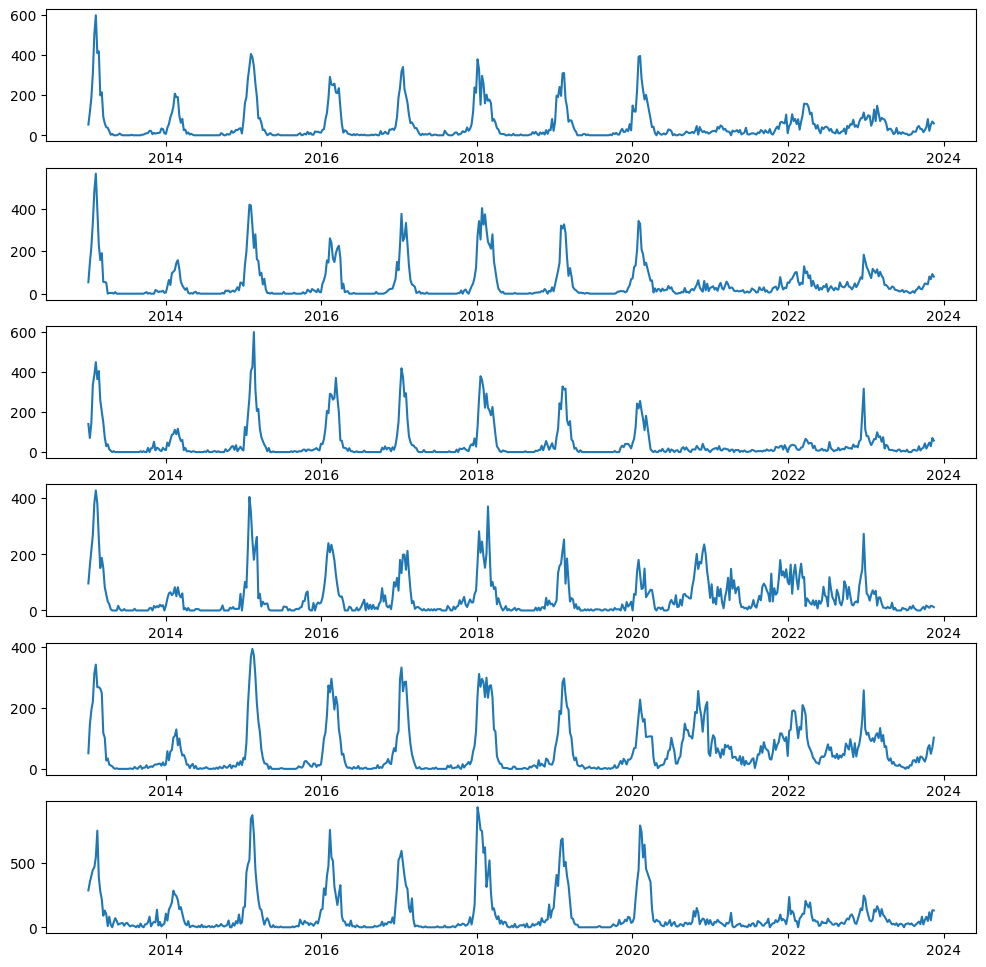

In [20]:
fig, ax = plt.subplots(6, figsize=(12, 12))
for i in range(1, 7):
    ax[i-1].plot(lagged_df.loc[lagged_df['georegion'] == f"region_{i}", 'incValue'])

### Some Feature Engineering

In [21]:
# create 1 year lag for flu cases
lagged_df['flu_cases_lagged'] = lagged_df.groupby('georegion')['flu_cases'].shift(52)

panel_df.sort_index(inplace=True)
panel_df['flu_cases_lagged'] = panel_df.groupby(level='georegion')['flu_cases'].shift(52)
panel_df

temporal  flu_cases  incValue  Bevölkerung 1. Januar  \
date       georegion                                                         
2013-01-03 region_1   2013-W01    16876.1     53.33              1693743.0   
           region_2   2013-W01    20530.5     53.58              1354954.0   
           region_3   2013-W01    13560.1    140.12              1350585.0   
           region_4   2013-W01    15599.2     96.16               765879.0   
           region_5   2013-W01    29374.0     51.07              2338327.0   
...                        ...        ...       ...                    ...   
2023-11-16 region_2   2023-W46    42445.8     80.10                    NaN   
           region_3   2023-W46    26246.4     57.15                    NaN   
           region_4   2023-W46    25170.5     11.92                    NaN   
           region_5   2023-W46    45003.1    102.22                    NaN   
           region_6   2023-W46    12301.9    130.06                    NaN   

                      Canton Size (km²)  weighted_avg_daily_temp_lagged  \
date       georegion                                                      
2013-01-03 region_1              9520.0                             NaN   
           region_2              8469.0                             NaN   
           region_3              2750.0                             NaN   
           region_4              4484.0                             NaN   
           region_5              6149.0                             NaN   
...                                 ...                             ...   
2023-11-16 region_2                 NaN                        7.114286   
           region_3                 NaN                        8.914286   
           region_4                 NaN                        8.071429   
           region_5                 NaN                        7.426559   
           region_6                 NaN                        7.565255   

                      weighted_avg_daily_hum_lagged  \
date       georegion                                  
2013-01-03 region_1                             NaN   
           region_2                             NaN   
           region_3                             NaN   
           region_4                             NaN   
           region_5                             NaN   
...                                             ...   
2023-11-16 region_2                       86.471429   
           region_3                       81.800000   
           region_4                       82.628571   
           region_5                       81.439495   
           region_6                       72.555931   

                      weighted_max_daily_temp_lagged  \
date       georegion                                   
2013-01-03 region_1                              NaN   
           region_2                              NaN   
           region_3                              NaN   
           region_4                              NaN   
           region_5                              NaN   
...                                              ...   
2023-11-16 region_2                        10.542857   
           region_3                        11.628571   
           region_4                        11.542857   
           region_5                        10.294136   
           region_6                        11.415706   

                      weighted_min_daily_temp_lagged  \
date       georegion                                   
2013-01-03 region_1                              NaN   
           region_2                              NaN   
           region_3                              NaN   
           region_4                              NaN   
           region_5                              NaN   
...                                              ...   
2023-11-16 region_2                         3.842857   
           region_3                         6.314286   
           region_4       

In [22]:
# dummies aus georegion machen
df_lagged_with_dummies = pd.get_dummies(lagged_df, columns=['georegion'], drop_first=False)
df_lagged_with_dummies.sort_index(inplace=True)
df_lagged_with_dummies

,temporal,flu_cases,incValue,Bevölkerung 1. Januar,Canton Size (km²),weighted_avg_daily_temp_lagged,weighted_avg_daily_hum_lagged,weighted_max_daily_temp_lagged,weighted_min_daily_temp_lagged,weighted_max_daily_hum_lagged,...,Pop Density_lagged,week_number,year,flu_cases_lagged,georegion_region_1,georegion_region_2,georegion_region_3,georegion_region_4,georegion_region_5,georegion_region_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,2013-W01,16876.1,53.33,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2013,NaN,True,False,False,False,False,False
2013-01-03,2013-W01,8425.9,284.84,535572.0,9917.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2013,NaN,False,False,False,False,False,True
2013-01-03,2013-W01,13560.1,140.12,1350585.0,2750.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2013,NaN,False,False,True,False,False,False
2013-01-03,2013-W01,15599.2,96.16,765879.0,4484.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2013,NaN,False,False,False,True,False,False
2013-01-03,2013-W01,20530.5,53.58,1354954.0,8469.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2013,NaN,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-16,2023-W46,25170.5,11.92,NaN,NaN,8.071429,82.628571,11.542857,4.785714,95.614286,...,214.648994,46,2023,27777.9,False,False,False,True,False,False
2023-11-16,2023-W46,42445.8,80.10,NaN,NaN,7.114286,86.471429,10.542857,3.842857,97.785714,...,154.738594,46,2023,45912.0,False,True,False,False,False,False
2023-11-16,2023-W46,26991.9,59.28,NaN,NaN,8.762207,78.783254,12.074802,5.320168,95.134631,...,591.956032,46,2023,32283.1,True,False,False,False,False,False


In [23]:
limited_time_df = df_lagged_with_dummies[pd.to_datetime(df_lagged_with_dummies.index) <= pd.Timestamp('2019-12-31')]

limited_panel_df = panel_df.loc[pd.to_datetime(panel_df.index.get_level_values('date')) <= pd.Timestamp('2019-12-31')]

In [24]:
limited_time_df

,temporal,flu_cases,incValue,Bevölkerung 1. Januar,Canton Size (km²),weighted_avg_daily_temp_lagged,weighted_avg_daily_hum_lagged,weighted_max_daily_temp_lagged,weighted_min_daily_temp_lagged,weighted_max_daily_hum_lagged,...,Pop Density_lagged,week_number,year,flu_cases_lagged,georegion_region_1,georegion_region_2,georegion_region_3,georegion_region_4,georegion_region_5,georegion_region_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,2013-W01,16876.1,53.33,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2013,NaN,True,False,False,False,False,False
2013-01-03,2013-W01,8425.9,284.84,535572.0,9917.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2013,NaN,False,False,False,False,False,True
2013-01-03,2013-W01,13560.1,140.12,1350585.0,2750.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2013,NaN,False,False,True,False,False,False
2013-01-03,2013-W01,15599.2,96.16,765879.0,4484.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2013,NaN,False,False,False,True,False,False
2013-01-03,2013-W01,20530.5,53.58,1354954.0,8469.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2013,NaN,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,2019-W52,11805.7,33.88,551722.0,9917.0,4.856655,56.176717,8.912273,0.958389,75.170892,...,76.788223,52,2019,10186.3,False,False,False,False,False,True
2019-12-26,2019-W52,20102.1,24.87,1819430.0,9520.0,2.515028,85.837239,4.918101,0.309942,94.531425,...,576.589505,52,2019,13456.3,True,False,False,False,False,False
2019-12-26,2019-W52,10839.9,18.45,1434299.0,2750.0,1.728571,85.985714,4.542857,-1.171429,94.942857,...,1662.154187,52,2019,10502.3,False,False,True,False,False,False


### Some Modelling YAY

In [62]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

year_len = 52 * 6
limited_panel_df.sort_index(inplace=True)

# Trainings- und Testdaten aufteilen
train_size = len(limited_panel_df) - year_len
train_data = limited_panel_df.iloc[:train_size]
test_data = limited_panel_df.iloc[train_size:]

X_train = train_data.drop(columns=['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']).values
y_train = train_data['incValue'].values

# Imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Kreuzvalidierung
tscv = TimeSeriesSplit(n_splits=5)
best_rmse = np.inf
best_model = None
best_depth = None

# Testen verschiedener Baumtiefen
for depth in range(1, 10):  # Zum Beispiel von 1 bis 9
    rmse_scores = []
    for train_index, test_index in tscv.split(X_train_imputed):
        X_train_cv, X_test_cv = X_train_imputed[train_index], X_train_imputed[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

        regressor = DecisionTreeRegressor(max_depth=depth)
        regressor.fit(X_train_cv, y_train_cv)

        predictions_cv = regressor.predict(X_test_cv)
        rmse_test_cv = np.sqrt(mean_squared_error(y_test_cv, predictions_cv))
        rmse_scores.append(rmse_test_cv)

    average_rmse = np.mean(rmse_scores)
    if average_rmse < best_rmse:
        best_rmse = average_rmse
        best_model = regressor
        best_depth = depth

print(f"Durchschnittlicher RMSE: {best_rmse}, Beste Baumtiefe: {best_depth}")

# Verwenden des besten Modells, um Vorhersagen für 2019 zu treffen
X_test_2019 = test_data.drop(columns=['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']).values
y_test_2019 = test_data['incValue'].values
X_test_2019_imputed = imputer.transform(X_test_2019)

predictions_2019 = best_model.predict(X_test_2019_imputed)
rmse_2019 = np.sqrt(mean_squared_error(y_test_2019, predictions_2019))

print(f"RMSE für das Jahr 2019: {rmse_2019}")

# Erstellen eines DataFrame für Vorhersagen und tatsächliche Werte
predictions_df = pd.DataFrame({
    'Predicted': predictions_2019,
    'True': y_test_2019
}, index=test_data.index)

# Berechnen des RMSE für jede Region
# Angenommen, die Regionen sind in einem MultiIndex auf der Ebene 'georegion'
for region in test_data.index.get_level_values('georegion').unique():
    region_data = predictions_df.loc[predictions_df.index.get_level_values('georegion') == region]
    rmse_region = np.sqrt(mean_squared_error(region_data['True'], region_data['Predicted']))
    print(f"RMSE für {region}: {rmse_region}")



C:\Users\finnl\AppData\Local\Temp\ipykernel_4940\4194106700.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_panel_df.sort_index(inplace=True)


Durchschnittlicher RMSE: 82.71208375617432, Beste Baumtiefe: 2
RMSE für das Jahr 2019: 47.479179552875785
RMSE für region_1: 37.44281245309912
RMSE für region_2: 49.16591462704305
RMSE für region_3: 48.282141773284806
RMSE für region_4: 43.11244971815797
RMSE für region_5: 34.567359394109474
RMSE für region_6: 65.73912617441661


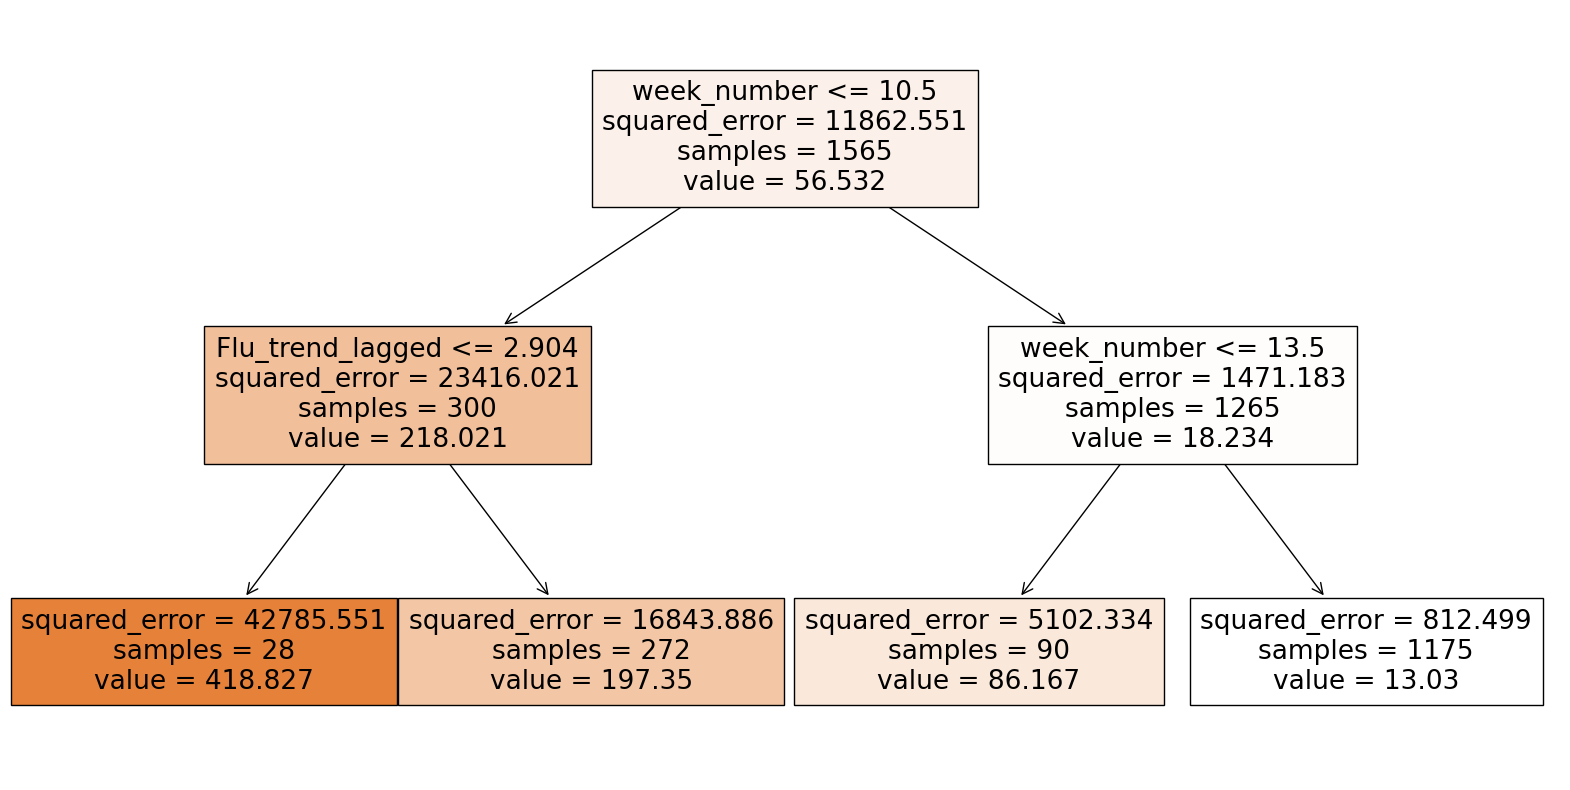

In [63]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Stellen Sie sicher, dass best_model das beste DecisionTreeRegressor Modell ist
if best_model:
    plt.figure(figsize=(20, 10))  # Größe des Plots anpassen
    plot_tree(best_model, filled=True, feature_names=train_data.columns.drop(['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']), class_names=['Low', 'Medium', 'High'])
    plt.show()
else:
    print("Kein Modell vorhanden.")


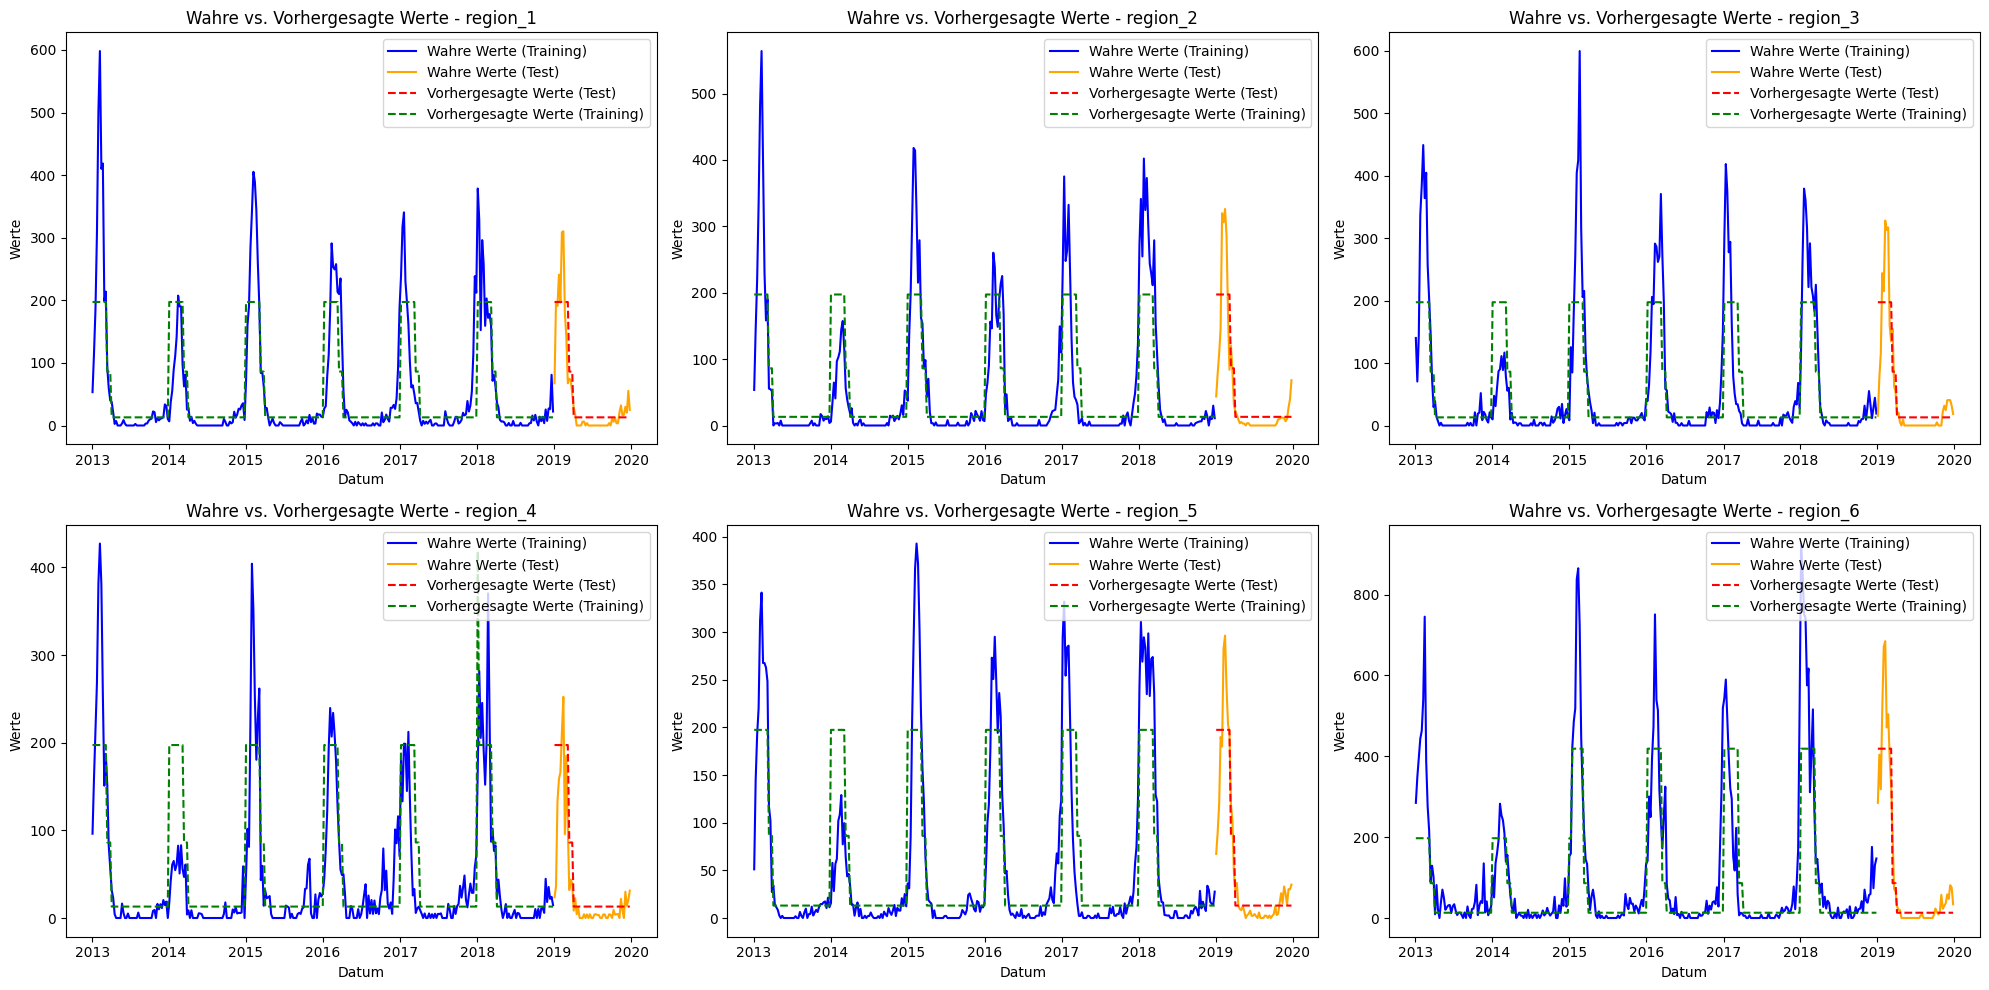

In [64]:
import matplotlib.pyplot as plt

# Extrahieren des Index für X_train und X_test
X_train_index = limited_panel_df.index[:-year_len]
X_test_index = limited_panel_df.index[-year_len:]

train_predictions = best_model.predict(X_train)

# Erstellen der DataFrames für die Vorhersagen
train_predictions_df = pd.DataFrame(train_predictions, index=X_train_index, columns=['Predicted'])
test_predictions_df = pd.DataFrame(predictions_2019, index=X_test_index, columns=['Predicted'])

# Hinzufügen der wahren Werte zu den DataFrames
train_predictions_df['True'] = y_train
test_predictions_df['True'] = y_test_2019

# Kombinieren der Trainings- und Testdaten
combined_predictions_df = pd.concat([train_predictions_df, test_predictions_df])

# Reset des Index
combined_predictions_df_reset = combined_predictions_df.reset_index()

# Setzen der Plot-Größe
plt.figure(figsize=(20, 10))

# Reset des Index für Trainings- und Testdaten
train_predictions_df_reset = train_predictions_df.reset_index()
test_predictions_df_reset = test_predictions_df.reset_index()

# Erstellen von Unterplots für jede Region
unique_regions = combined_predictions_df_reset['georegion'].unique()
for i, region in enumerate(unique_regions, 1):
    plt.subplot(2, 3, i)  # 2 Reihen, 3 Spalten, aktueller Unterplot i

    # Filtern der Trainings- und Testdaten für die aktuelle Region
    train_region_data = train_predictions_df_reset[train_predictions_df_reset['georegion'] == region]
    test_region_data = test_predictions_df_reset[test_predictions_df_reset['georegion'] == region]

    plt.plot(train_region_data['date'], train_region_data['True'], color='blue', label='Wahre Werte (Training)')
    plt.plot(test_region_data['date'], test_region_data['True'], color='orange', label='Wahre Werte (Test)')
    plt.plot(test_region_data['date'], test_region_data['Predicted'], 'r--', label='Vorhergesagte Werte (Test)')
    plt.plot(train_region_data['date'], train_region_data['Predicted'], 'g--', label='Vorhergesagte Werte (Training)')

    plt.title(f'Wahre vs. Vorhergesagte Werte - {region}')
    plt.xlabel('Datum')
    plt.ylabel('Werte')
    plt.legend()

# Anzeigen des Gesamtplots
plt.tight_layout()  # Passt die Unterplots in den Plot-Bereich ein
plt.show()


In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

year_len = 52 * 6
limited_panel_df.sort_index(inplace=True)

# Trainings- und Testdaten aufteilen
train_size = len(limited_panel_df) - year_len
train_data = limited_panel_df.iloc[:train_size]
test_data = limited_panel_df.iloc[train_size:]

X_train = train_data.drop(columns=['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']).values
y_train = train_data['incValue'].values

# Imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

best_rmse = np.inf
best_model = None

# Parameter für die Gittersuche
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialisierung des RandomForestRegressor
rf = RandomForestRegressor(random_state=0)

# Gittersuche
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Training der Modelle
grid_search.fit(X_train_imputed, y_train)

# Beste Parameter
best_params = grid_search.best_params_
print(f"Beste Parameter: {best_params}")

# Beste Modell
best_model = grid_search.best_estimator_

# Verwenden des besten Modells, um Vorhersagen für 2019 zu treffen
X_test_2019 = test_data.drop(columns=['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']).values
y_test_2019 = test_data['incValue'].values
X_test_2019_imputed = imputer.transform(X_test_2019)

predictions_2019 = best_model.predict(X_test_2019_imputed)
rmse_2019 = np.sqrt(mean_squared_error(y_test_2019, predictions_2019))

print(f"RMSE für das Jahr 2019: {rmse_2019}")

# Erstellen eines DataFrame für Vorhersagen und tatsächliche Werte
predictions_df = pd.DataFrame({
    'Predicted': predictions_2019,
    'True': y_test_2019
}, index=test_data.index)

# Berechnen des RMSE für jede Region
# Angenommen, die Regionen sind in einem MultiIndex auf der Ebene 'georegion'
for region in test_data.index.get_level_values('georegion').unique():
    region_data = predictions_df.loc[predictions_df.index.get_level_values('georegion') == region]
    rmse_region = np.sqrt(mean_squared_error(region_data['True'], region_data['Predicted']))
    print(f"RMSE für {region}: {rmse_region}")



C:\Users\finnl\AppData\Local\Temp\ipykernel_4940\1101611744.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_panel_df.sort_index(inplace=True)


Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Beste Parameter: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
RMSE für das Jahr 2019: 61.98637373194054
RMSE für region_1: 33.03359785679691
RMSE für region_2: 41.82415521146214
RMSE für region_3: 41.245480018133165
RMSE für region_4: 44.03238181166072
RMSE für region_5: 36.48161161864196
RMSE für region_6: 123.46026230277607


In [77]:
best_model

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=4, n_estimators=10, random_state=0)

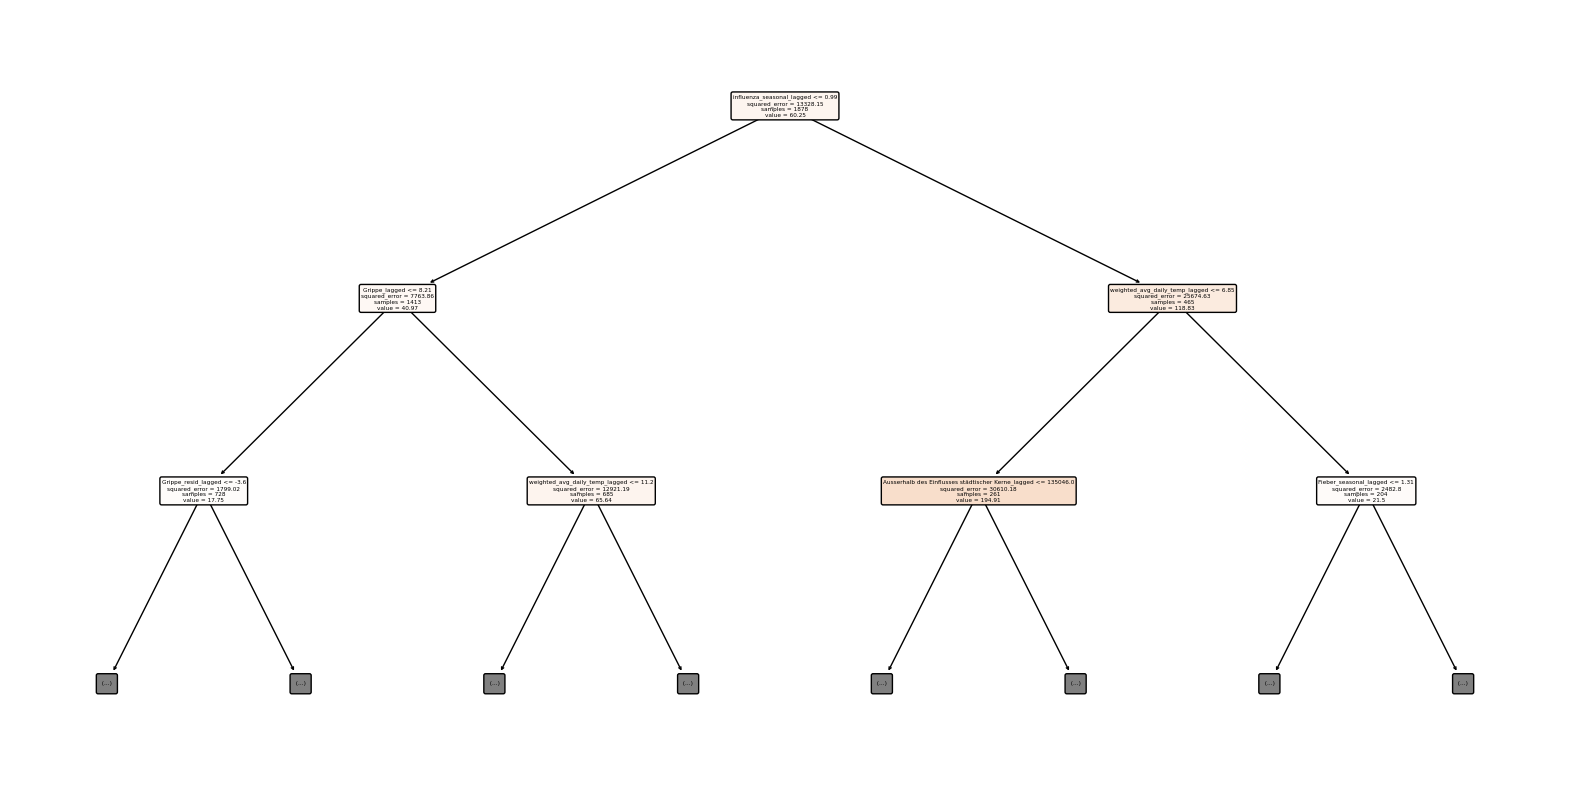

In [87]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Wählen Sie einen Baum aus dem Random Forest (z.B. den ersten Baum)
tree = best_model.estimators_[0]

# Visualisieren Sie den Baum
plt.figure(figsize=(20,10))
plot_tree(tree, 
          feature_names=train_data.columns.drop(['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']), 
          class_names=['Low', 'Medium', 'High'], 
          filled=True, 
          rounded=True, 
          precision=2,
          max_depth=2)
plt.show()


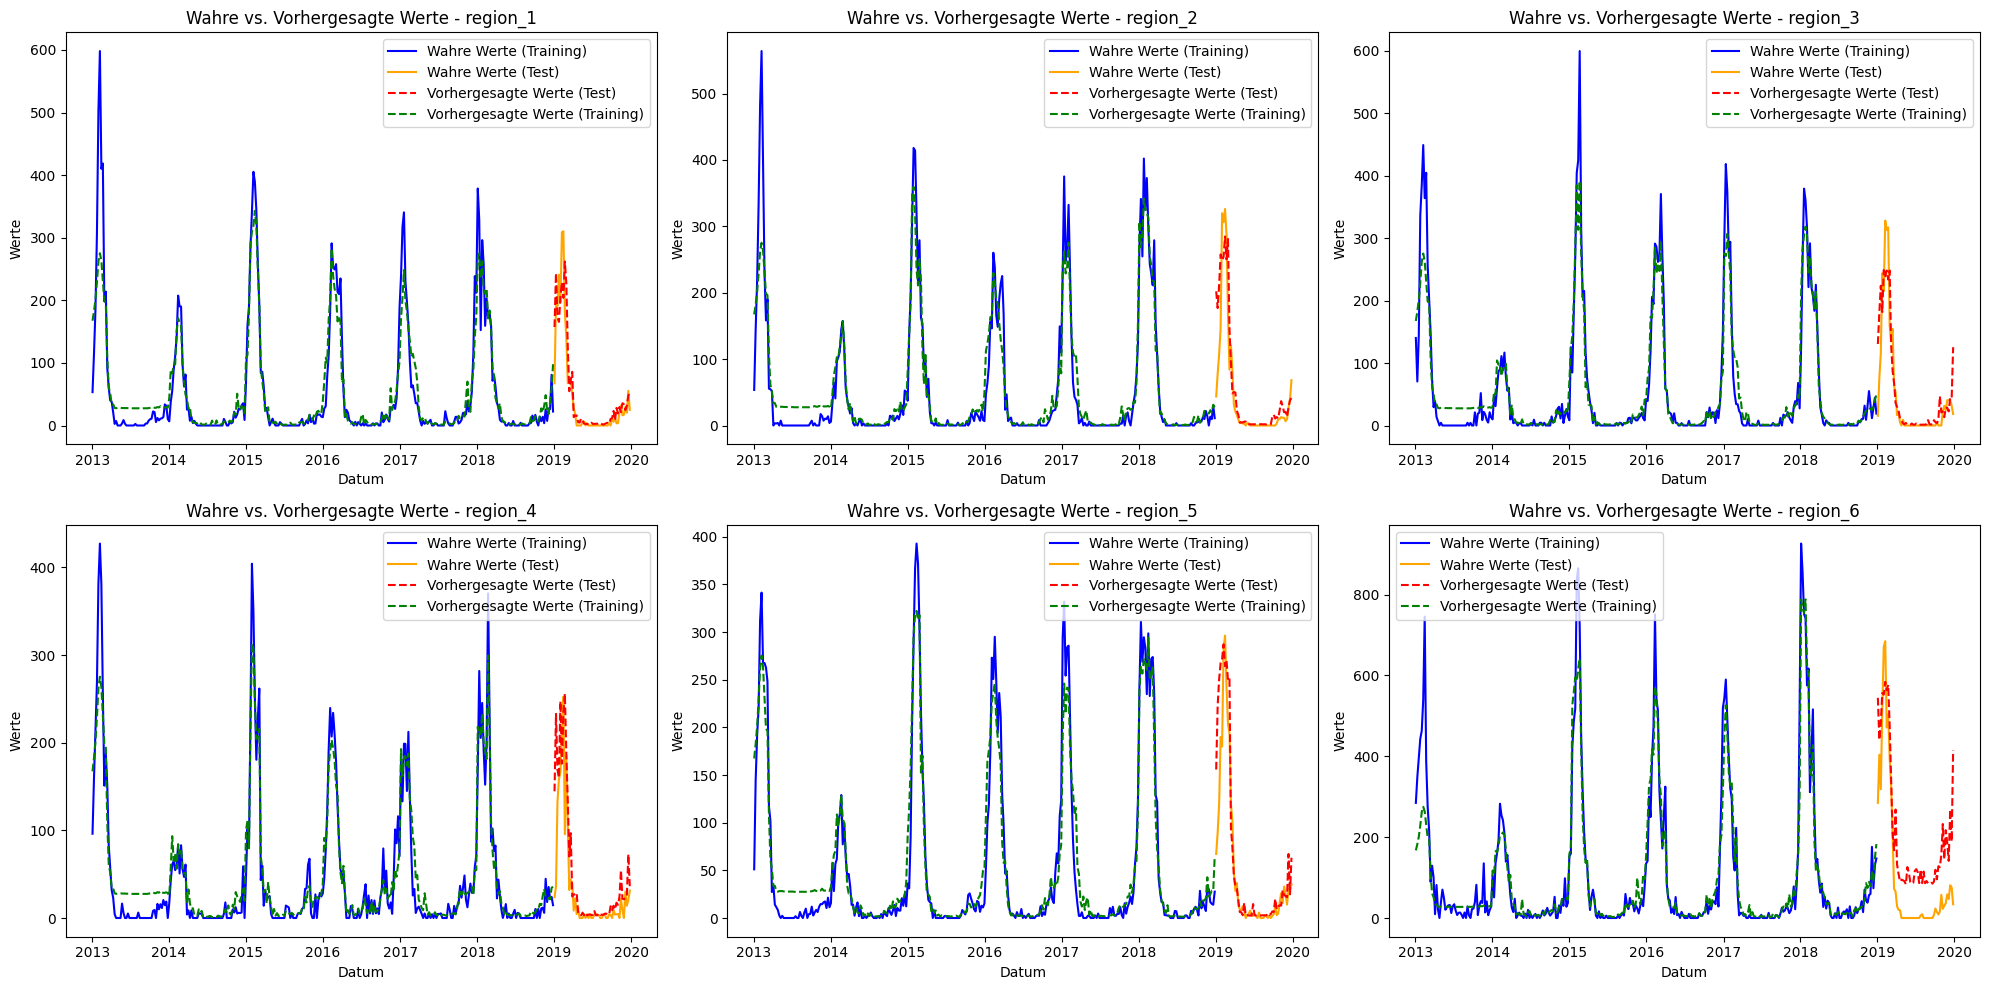

In [74]:
import matplotlib.pyplot as plt

# Verwenden von X_train_imputed für die Vorhersagen auf Trainingsdaten
train_predictions = best_model.predict(X_train_imputed)

# Der Rest des Codes bleibt gleich
train_predictions_df = pd.DataFrame(train_predictions, index=X_train_index, columns=['Predicted'])
test_predictions_df = pd.DataFrame(predictions_2019, index=X_test_index, columns=['Predicted'])

# Hinzufügen der wahren Werte zu den DataFrames
train_predictions_df['True'] = y_train
test_predictions_df['True'] = y_test_2019

# Kombinieren der Trainings- und Testdaten
combined_predictions_df = pd.concat([train_predictions_df, test_predictions_df])

# Reset des Index
combined_predictions_df_reset = combined_predictions_df.reset_index()

# Setzen der Plot-Größe
plt.figure(figsize=(20, 10))

# Reset des Index für Trainings- und Testdaten
train_predictions_df_reset = train_predictions_df.reset_index()
test_predictions_df_reset = test_predictions_df.reset_index()

# Erstellen von Unterplots für jede Region
unique_regions = combined_predictions_df_reset['georegion'].unique()
for i, region in enumerate(unique_regions, 1):
    plt.subplot(2, 3, i)  # 2 Reihen, 3 Spalten, aktueller Unterplot i

    # Filtern der Trainings- und Testdaten für die aktuelle Region
    train_region_data = train_predictions_df_reset[train_predictions_df_reset['georegion'] == region]
    test_region_data = test_predictions_df_reset[test_predictions_df_reset['georegion'] == region]

    plt.plot(train_region_data['date'], train_region_data['True'], color='blue', label='Wahre Werte (Training)')
    plt.plot(test_region_data['date'], test_region_data['True'], color='orange', label='Wahre Werte (Test)')
    plt.plot(test_region_data['date'], test_region_data['Predicted'], 'r--', label='Vorhergesagte Werte (Test)')
    plt.plot(train_region_data['date'], train_region_data['Predicted'], 'g--', label='Vorhergesagte Werte (Training)')

    plt.title(f'Wahre vs. Vorhergesagte Werte - {region}')
    plt.xlabel('Datum')
    plt.ylabel('Werte')
    plt.legend()

# Anzeigen des Gesamtplots
plt.tight_layout()  # Passt die Unterplots in den Plot-Bereich ein
plt.show()
